<a href="https://colab.research.google.com/github/JangAyeon/TIL/blob/main/3_5_classifying_newswires_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
keras.__version__

'2.6.0'

# 뉴스 기사 분류: 다중 분류 문제

이 노트북은 [케라스 창시자에게 배우는 딥러닝](https://tensorflow.blog/%EC%BC%80%EB%9D%BC%EC%8A%A4-%EB%94%A5%EB%9F%AC%EB%8B%9D/) 책의 3장 5절의 코드 예제입니다. 책에는 더 많은 내용과 그림이 있습니다. 이 노트북에는 소스 코드에 관련된 설명만 포함합니다.

----

이전 섹션에서 완전 연결된 신경망을 사용해 벡터 입력을 어떻게 두 개의 클래스로 분류하는지 보았습니다. 두 개 이상의 클래스가 있을 때는 어떻게 해야 할까요?

이 절에서 로이터 뉴스를 46개의 상호 배타적인 토픽으로 분류하는 신경망을 만들어 보겠습니다. 클래스가 많기 때문에 이 문제는 다중 분류의 예입니다. 각 데이터 포인트가 정확히 하나의 범주로 분류되기 때문에 좀 더 정확히 말하면 단일 레이블 다중 분류 문제입니다. 각 데이터 포인트가 여러 개의 범주(가령, 토픽)에 속할 수 있다면 이런 문제는 다중 레이블 다중 분류의 문제가 됩니다.

## 로이터 데이터셋

1986년에 로이터에서 공개한 짧은 뉴스 기사와 토픽의 집합인 로이터 데이터셋을 사용하겠습니다. 이 데이터셋은 텍스트 분류를 위해 널리 사용되는 간단한 데이터셋입니다. 46개의 토픽이 있으며 어떤 토픽은 다른 것에 비해 데이터가 많습니다. 각 토픽은 훈련 세트에 최소한 10개의 샘플을 가지고 있습니다.

IMDB와 MNIST와 마찬가지로 로이터 데이터셋은 케라스에 포함되어 있습니다. 한 번 살펴보죠:

In [ ]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2121728/2110848 [==============================] - 0s 0us/step


IMDB 데이터셋에서처럼 num_words=10000 매개변수는 데이터에서 가장 자주 등장하는 단어 10,000개로 제한합니다.

여기에는 8,982개의 훈련 샘플과 2,246개의 테스트 샘플이 있습니다:

In [ ]:
len(train_data)

8982

In [ ]:
len(test_data)

2246

IMDB 리뷰처럼 각 샘플은 정수 리스트입니다(단어 인덱스):

In [ ]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

궁금한 경우를 위해 어떻게 단어로 디코딩하는지 알아보겠습니다:

In [ ]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# 0, 1, 2는 '패딩', '문서 시작', '사전에 없음'을 위한 인덱스이므로 3을 뺍니다
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

565248/550378 [==============================] - 0s 0us/step


In [ ]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

샘플에 연결된 레이블은 토픽의 인덱스로 0과 45 사이의 정수입니다.

In [ ]:
train_labels[10]

3

## 데이터 준비

이전의 예제와 동일한 코드를 사용해서 데이터를 벡터로 변환합니다:

In [ ]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# 훈련 데이터 벡터 변환
x_train = vectorize_sequences(train_data)
# 테스트 데이터 벡터 변환
x_test = vectorize_sequences(test_data)

레이블을 벡터로 바꾸는 방법은 두 가지입니다. 레이블의 리스트를 정수 텐서로 변환하는 것과 원-핫 인코딩을 사용하는 것입니다. 원-핫 인코딩이 범주형 데이터에 널리 사용되기 때문에 범주형 인코딩이라고도 부릅니다. 원-핫 인코딩에 대한 자세한 설명은 6.1절을 참고하세요. 이 경우 레이블의 원-핫 인코딩은 각 레이블의 인덱스 자리는 1이고 나머지는 모두 0인 벡터입니다:

In [ ]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# 훈련 레이블 벡터 변환
one_hot_train_labels = to_one_hot(train_labels)
# 테스트 레이블 벡터 변환
one_hot_test_labels = to_one_hot(test_labels)

MNIST 예제에서 이미 보았듯이 케라스에는 이를 위한 내장 함수가 있습니다:

In [ ]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## 모델 구성

이 토픽 분류 문제는 이전의 영화 리뷰 분류 문제와 비슷해 보입니다. 두 경우 모두 짧은 텍스트를 분류하는 것이죠. 여기에서는 새로운 제약 사항이 추가되었습니다. 출력 클래스의 개수가 2에서 46개로 늘어난 점입니다. 출력 공간의 차원이 훨씬 커졌습니다.

이전에 사용했던 것처럼 `Dense` 층을 쌓으면 각 층은 이전 층의 출력에서 제공한 정보만 사용할 수 있습니다. 한 층이 분류 문제에 필요한 일부 정보를 누락하면 그 다음 층에서 이를 복원할 방법이 없습니다. 각 층은 잠재적으로 정보의 병목이 될 수 있습니다. 이전 예제에서 16차원을 가진 중간층을 사용했지만 16차원 공간은 46개의 클래스를 구분하기에 너무 제약이 많을 것 같습니다. 이렇게 규모가 작은 층은 유용한 정보를 완전히 잃게 되는 정보의 병목 지점처럼 동작할 수 있습니다.

이런 이유로 좀 더 규모가 큰 층을 사용하겠습니다. 64개의 유닛을 사용해 보죠:

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

이 구조에서 주목해야 할 점이 두 가지 있습니다:

* 마지막 `Dense` 층의 크기가 46입니다. 각 입력 샘플에 대해서 46차원의 벡터를 출력한다는 뜻입니다. 이 벡터의 각 원소(각 차원)은 각기 다른 출력 클래스가 인코딩된 것입니다.
* 마지막 층에 `softmax` 활성화 함수가 사용되었습니다. MNIST 예제에서 이런 방식을 보았습니다. 각 입력 샘플마다 46개의 출력 클래스에 대한 확률 분포를 출력합니다. 즉, 46차원의 출력 벡터를 만들며 `output[i]`는 어떤 샘플이 클래스 `i`에 속할 확률입니다. 46개의 값을 모두 더하면 1이 됩니다.

이런 문제에 사용할 최선의 손실 함수는 `categorical_crossentropy`입니다. 이 함수는 두 확률 분포의 사이의 거리를 측정합니다. 여기에서는 네트워크가 출력한 확률 분포와 진짜 레이블의 분포 사이의 거리입니다. 두 분포 사이의 거리를 최소화하면 진짜 레이블에 가능한 가까운 출력을 내도록 모델을 훈련하게 됩니다.

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 훈련 검증

훈련 데이터에서 1,000개의 샘플을 따로 떼어서 검증 세트로 사용하겠습니다:

In [ ]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

이제 20번의 에포크로 모델을 훈련시킵니다:

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 2s 63ms/step - loss: 2.7838 - accuracy: 0.5053 - val_loss: 1.8422 - val_accuracy: 0.6350
Epoch 2/20
16/16 [==============================] - 1s 48ms/step - loss: 1.4700 - accuracy: 0.7017 - val_loss: 1.3237 - val_accuracy: 0.7140
Epoch 3/20
16/16 [==============================] - 1s 48ms/step - loss: 1.0569 - accuracy: 0.7843 - val_loss: 1.1294 - val_accuracy: 0.7610
Epoch 4/20
16/16 [==============================] - 1s 49ms/step - loss: 0.8333 - accuracy: 0.8231 - val_loss: 1.0328 - val_accuracy: 0.7880
Epoch 5/20
16/16 [==============================] - 1s 49ms/step - loss: 0.6689 - accuracy: 0.8582 - val_loss: 1.0024 - val_accuracy: 0.7910
Epoch 6/20
16/16 [==============================] - 1s 48ms/step - loss: 0.5388 - accuracy: 0.8889 - val_loss: 0.9450 - val_accuracy: 0.8030
Epoch 7/20
16/16 [==============================] - 1s 49ms/step - loss: 0.4399 - accuracy: 0.9074 - val_loss: 0.9239 - val_accuracy: 0.8070
Epoch 8/20
16

손실과 정확도 곡선을 그려 보죠:

In [ ]:
import matplotlib.pyplot as plt

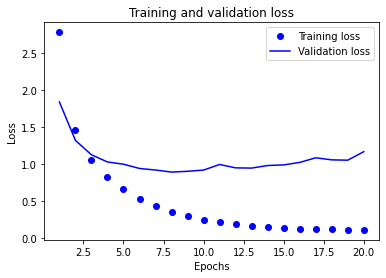

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

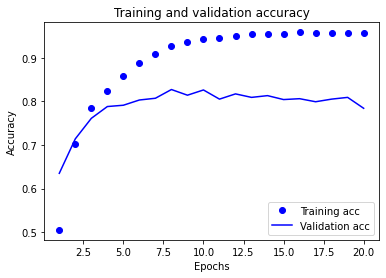

In [ ]:
plt.clf()   # 그래프를 초기화합니다

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

이 모델은 9번째 에포크 이후에 과대적합이 시작됩니다. 9번의 에포크로 새로운 모델을 훈련하고 테스트 세트에서 평가하겠습니다:

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 2s 61ms/step - loss: 2.7368 - accuracy: 0.5286 - val_loss: 1.7408 - val_accuracy: 0.6270
Epoch 2/9
16/16 [==============================] - 1s 48ms/step - loss: 1.4275 - accuracy: 0.7067 - val_loss: 1.2916 - val_accuracy: 0.7190
Epoch 3/9
16/16 [==============================] - 1s 49ms/step - loss: 1.0503 - accuracy: 0.7826 - val_loss: 1.1431 - val_accuracy: 0.7490
Epoch 4/9
16/16 [==============================] - 1s 49ms/step - loss: 0.8334 - accuracy: 0.8274 - val_loss: 1.0666 - val_accuracy: 0.7900
Epoch 5/9
16/16 [==============================] - 1s 49ms/step - loss: 0.6638 - accuracy: 0.8687 - val_loss: 0.9883 - val_accuracy: 0.7930
Epoch 6/9
16/16 [==============================] - 1s 49ms/step - loss: 0.5351 - accuracy: 0.8916 - val_loss: 0.9387 - val_accuracy: 0.8100
Epoch 7/9
16/16 [==============================] - 1s 48ms/step - loss: 0.4299 - accuracy: 0.9126 - val_loss: 0.9208 - val_accuracy: 0.8060
Epoch 8/9
16/16 [===

In [ ]:
results

대략 78%의 정확도를 달성했습니다. 균형 잡힌 이진 분류 문제에서 완전히 무작위로 분류하면 50%의 정확도를 달성합니다. 이 문제는 불균형한 데이터셋을 사용하므로 무작위로 분류하면 19% 정도를 달성합니다. 여기에 비하면 이 결과는 꽤 좋은 편입니다:

In [ ]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

## 새로운 데이터에 대해 예측하기

모델 인스턴스의 `predict` 메서드는 46개 토픽에 대한 확률 분포를 반환합니다. 테스트 데이터 전체에 대한 토픽을 예측해 보겠습니다:

In [ ]:
predictions = model.predict(x_test)

`predictions`의 각 항목은 길이가 46인 벡터입니다:

In [ ]:
predictions[0].shape

이 벡터의 원소 합은 1입니다:

In [ ]:
np.sum(predictions[0])

가장 큰 값이 예측 클래스가 됩니다. 즉, 가장 확률이 높은 클래스입니다:

In [ ]:
np.argmax(predictions[0])

## 레이블과 손실을 다루는 다른 방법

앞서 언급한 것처럼 레이블을 인코딩하는 다른 방법은 다음과 같이 정수 텐서로 변환하는 것입니다:

In [ ]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

이 방식을 사용하려면 손실 함수 하나만 바꾸면 됩니다. 코드 3-21에 사용된 손실 함수 `categorical_crossentropy`는 레이블이 범주형 인코딩되어 있을 것이라고 기대합니다. 정수 레이블을 사용할 때는 `sparse_categorical_crossentropy`를 사용해야 합니다:

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

이 손실 함수는 인터페이스만 다를 뿐이고 수학적으로는 `categorical_crossentropy`와 동일합니다.

## 충분히 큰 중간층을 두어야 하는 이유

앞서 언급한 것처럼 마지막 출력이 46차원이기 때문에 중간층의 히든 유닛이 46개보다 많이 적어서는 안 됩니다. 46차원보다 훨씬 작은 중간층(예를 들면 4차원)을 두면 정보의 병목이 어떻게 나타나는지 확인해 보겠습니다.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

검증 정확도의 최고 값은 약 71%로 8% 정도 감소되었습니다. 이런 손실의 대부분 원인은 많은 정보(46개 클래스의 분할 초평면을 복원하기에 충분한 정보)를 중간층의 저차원 표현 공간으로 압축하려고 했기 때문입니다. 이 네트워크는 필요한 정보 대부분을 4차원 표현 안에 구겨 넣었지만 전부는 넣지 못했습니다.

## 추가 실험

* 더 크거나 작은 층을 사용해 보세요: 32개 유닛, 128개 유닛 등
* 여기에서 두 개의 은닉층을 사용했습니다. 한 개의 은닉층이나 세 개의 은닉층을 사용해 보세요.

## 정리

다음은 이 예제에서 배운 것들입니다.

* N개의 클래스로 데이터 포인트를 분류하려면 네트워크의 마지막 `Dense` 층의 크기는 N이어야 합니다.
* 단일 레이블, 다중 분류 문제에서는 N개의 클래스에 대한 확률 분포를 출력하기 위해 `softmax` 활성화 함수를 사용해야 합니다.
* 이런 문제에는 항상 범주형 크로스엔트로피를 사용해야 합니다. 이 함수는 모델이 출력한 확률 분포와 타깃 분포 사이의 거리를 최소화합니다.
* 다중 분류에서 레이블을 다루는 두 가지 방법이 있습니다.
    * 레이블을 범주형 인코딩(또는 원-핫 인코딩)으로 인코딩하고 `categorical_crossentropy` 손실 함수를 사용합니다.
    * 레이블을 정수로 인코딩하고 `sparse_categorical_crossentropy` 손실 함수를 사용합니다.
* 많은 수의 범주를 분류할 때 중간층의 크기가 너무 작아 네트워크에 정보의 병목이 생기지 않도록 해야 합니다.